<a href="https://colab.research.google.com/github/j-ranasinghe/Spam-E-mail-Classification/blob/main/Spam_E_mail_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries

In [306]:
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Importing the dataset

In [307]:
cols = ['capital_run_length_total','capital_run_length_longest','capital_run_length_average','char_freq_#','char_freq_$','char_freq_!','char_freq_[','char_freq_(','char_freq_;','word_freq_conference','word_freq_table','word_freq_edu','word_freq_re','word_freq_project','word_freq_original','word_freq_meeting','word_freq_cs','word_freq_direct','word_freq_pm','word_freq_parts','word_freq_1999','word_freq_technology','word_freq_85','word_freq_415','word_freq_data','word_freq_857','word_freq_telnet','word_freq_labs','word_freq_lab','word_freq_650','word_freq_george','word_freq_hpl','word_freq_hp','word_freq_money','word_freq_000','word_freq_font','word_freq_your','word_freq_credit','word_freq_you','word_freq_email','word_freq_business','word_freq_free','word_freq_addresses','word_freq_report','word_freq_people','word_freq_will','word_freq_receive','word_freq_mail','word_freq_order','word_freq_internet','word_freq_remove','word_freq_over','word_freq_our','word_freq_3d','word_freq_all','word_freq_address','word_freq_make','class']
df = pd.read_csv('spambase.data' , names= cols )
print(df.head())

   capital_run_length_total  capital_run_length_longest  \
0                      0.00                        0.64   
1                      0.21                        0.28   
2                      0.06                        0.00   
3                      0.00                        0.00   
4                      0.00                        0.00   

   capital_run_length_average  char_freq_#  char_freq_$  char_freq_!  \
0                        0.64          0.0         0.32         0.00   
1                        0.50          0.0         0.14         0.28   
2                        0.71          0.0         1.23         0.19   
3                        0.00          0.0         0.63         0.00   
4                        0.00          0.0         0.63         0.00   

   char_freq_[  char_freq_(  char_freq_;  word_freq_conference  ...  \
0         0.00         0.00         0.00                  0.00  ...   
1         0.21         0.07         0.00                  0.94  ...   

# Data Visualisation

In [265]:
print(df.dtypes) #Check the data type of the attributes


capital_run_length_total      float64
capital_run_length_longest    float64
capital_run_length_average    float64
char_freq_#                   float64
char_freq_$                   float64
char_freq_!                   float64
char_freq_[                   float64
char_freq_(                   float64
char_freq_;                   float64
word_freq_conference          float64
word_freq_table               float64
word_freq_edu                 float64
word_freq_re                  float64
word_freq_project             float64
word_freq_original            float64
word_freq_meeting             float64
word_freq_cs                  float64
word_freq_direct              float64
word_freq_pm                  float64
word_freq_parts               float64
word_freq_1999                float64
word_freq_technology          float64
word_freq_85                  float64
word_freq_415                 float64
word_freq_data                float64
word_freq_857                 float64
word_freq_te

In [266]:
print(df.shape) #Check the shape of the dataset

(4601, 58)


In [308]:
#Check the distribution of the spam vs not-spam 
new_class = pd.Categorical(df["class"])
new_class = new_class.rename_categories(["spam","not_spam"])              
new_class.describe()

,counts,freqs
categories,,
spam,2788,0.605955
not_spam,1813,0.394045


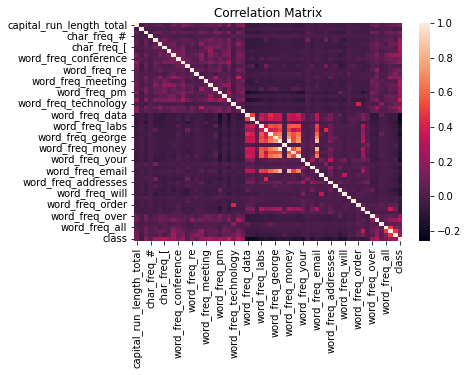

In [268]:
# Get the correlation matrix
correlation_matrix = df.corr()
# plot the correlation matrix
sns.heatmap(correlation_matrix)
plt.title('Correlation Matrix')
plt.show()

#Data Cleaning

In [309]:
# Find NaNs and duplicates in df

print(' {} missing values '
      .format(df.isnull().values.sum()))

temp_energy = df.duplicated(keep='first').sum()

print(' {} duplicate rows '
      .format(temp_energy))

df = df.drop_duplicates()   #drop the duplicates

 0 missing values 
 391 duplicate rows 


In [310]:
# extract the features
features = df.drop('class', axis=1)
# extract the labels
labels = df['class']

In [311]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [312]:
# Handle outliers
X_winsorized = winsorize(X_scaled, limits=[0.05, 0.05])

# PCA

In [313]:
pca = PCA(n_components= 20)
X_pca = pca.fit_transform(X_winsorized)

In [314]:
pca.explained_variance_ratio_ # get the explained variance ratios

array([0.16472633, 0.09236153, 0.05307039, 0.04030148, 0.03884343,
       0.03434102, 0.03241762, 0.03070964, 0.02871472, 0.02647561,
       0.0250819 , 0.02319337, 0.02268474, 0.02104289, 0.02057252,
       0.01968953, 0.01861293, 0.01792306, 0.01666161, 0.01608918])

In [315]:
pca.explained_variance_ratio_.sum() # display the sum of explained variance ratios

0.7435135096637453

In [316]:
print(X_winsorized.shape) # shape of dataframe before applying PCA
print(X_pca.shape) # shape of dataframe after applying PCA

(4210, 57)
(4210, 20)




---



In [317]:
# handle class imbalance using oversampling technique
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_pca, labels)

In [318]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=0)

# KNN classification

In [319]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Evaluations

In [320]:
# calculate and store accuracy score
score = accuracy_score(y_test, y_pred) 

# get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)   

# get the classification report
class_report = classification_report(y_test, y_pred) 

# print results
print("Accuracy score:", score)
print("Confusion matrix:")
print(conf_matrix)
print("\nClassification report:")
print(class_report)

Accuracy score: 0.9320695102685624
Confusion matrix:
[[589  44]
 [ 42 591]]

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       633
           1       0.93      0.93      0.93       633

    accuracy                           0.93      1266
   macro avg       0.93      0.93      0.93      1266
weighted avg       0.93      0.93      0.93      1266



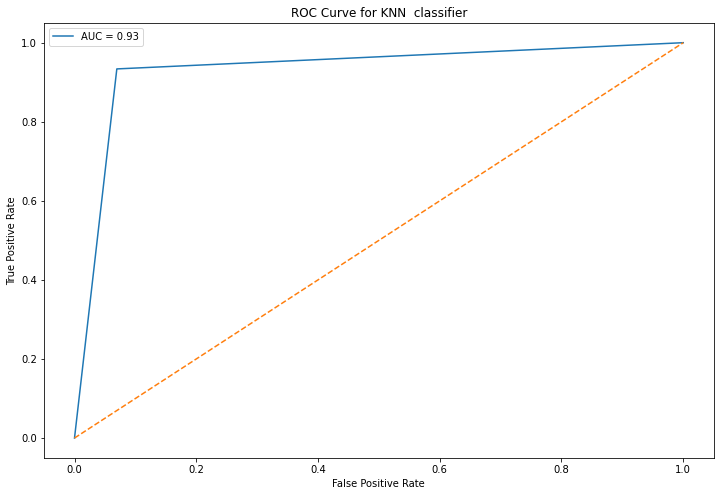

In [321]:
# calculate ROC curve for KNN classifier
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

#Calculate the auc score for KNN classifier
auc_score = auc(fpr,tpr)

#  plotting the roc curve for KNN classifier
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc_score)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for KNN  classifier')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)



---



# Decision Tree classification

In [282]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred1 = dtc.predict(X_test)
y_true1 = y_test

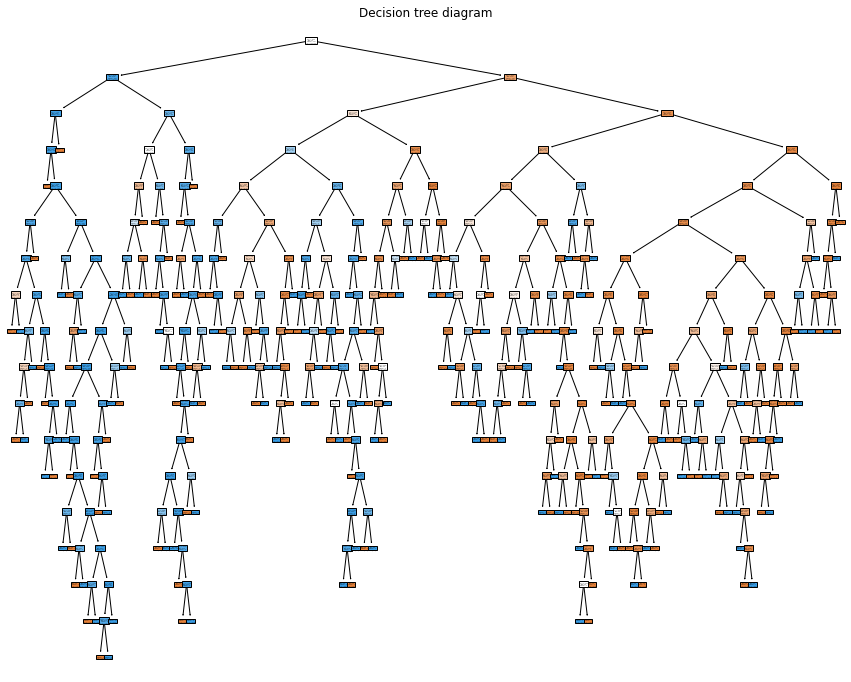

In [325]:
# Plot the decision tree
plt.figure(figsize=(15,12))
tree.plot_tree(dtc,filled=True)
plt.title('Decision tree diagram')

plt.show()

# Evaluations

In [322]:
# calculate and store accuracy score
score1 = accuracy_score(y_true1, y_pred1) 

# get the confusion matrix
conf_matrix1 = confusion_matrix(y_true1, y_pred1)   

# get the classification report
class_report1 = classification_report(y_true1, y_pred1) 

# print results
print("Accuracy score:", score1)
print("Confusion matrix:")
print(conf_matrix1)
print("\nClassification report:")
print(class_report1)

Accuracy score: 0.9036334913112164
Confusion matrix:
[[563  70]
 [ 52 581]]

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       633
           1       0.89      0.92      0.90       633

    accuracy                           0.90      1266
   macro avg       0.90      0.90      0.90      1266
weighted avg       0.90      0.90      0.90      1266



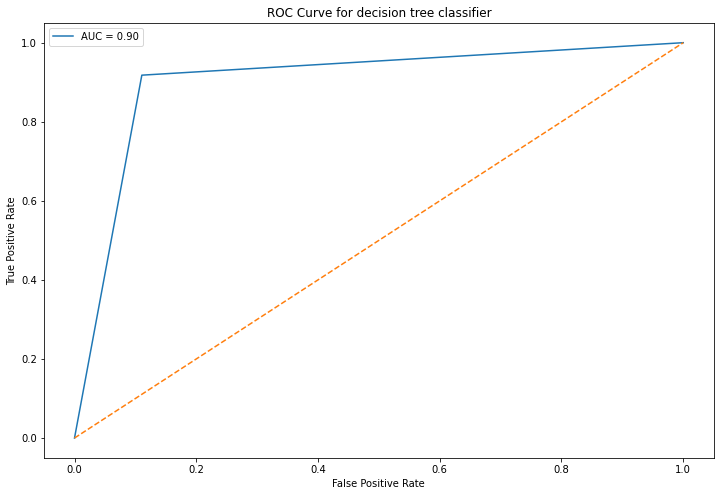

In [323]:
# calculate ROC curve for Decision tree classifier
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)

# Calculate the auc score for Decision tree classifier
auc_score = auc(fpr,tpr)

# plot the roc curve for Decision tree classifier
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, label='AUC = %0.2f' % auc_score)
    plt.plot([0, 1], [0, 1],  linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for decision tree classifier')
    plt.legend()
    plt.show()
plot_roc_curve(fpr,tpr)